In [1]:
# the aim is to end up with train, test, evaluate
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [2]:
import src.ads_davidjames9610.ads as ads
import src.ads_davidjames9610.useful as useful
import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload
import importlib
import src.classifiers_davidjames9610.test_a.config as base_config
reload(base_config)
config = importlib.import_module('src.classifiers_davidjames9610.test_a.whale_data.config')
reload(config)
print(config.basedir)
import src.misc_davidjames9610.fe_methods as fe
import src.misc_davidjames9610.proc_methods as pm

/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/whale_data


In [3]:
import src.misc_davidjames9610.utils as utils
sls = utils.load_pickle(config.samples_labels)

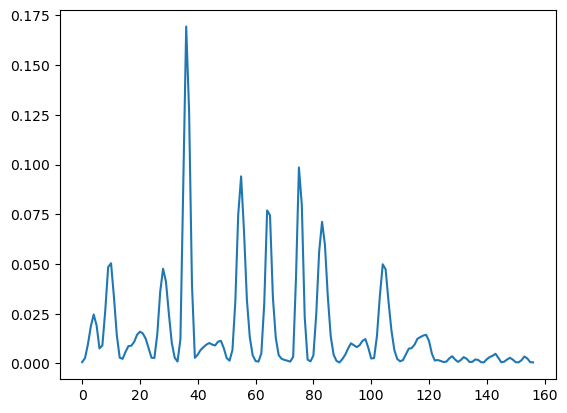

0.016782008667436277
0.009859741681539906


In [4]:
# going to have to do fe after cross-validation split
import src.misc_davidjames9610.cross_validation as cv
from src.misc_davidjames9610.cross_validation import *
import importlib
importlib.reload(cv)
from src.classifiers_davidjames9610.test_a import b_samples_to_features as feat_proc
reload(feat_proc)
import src.misc_davidjames9610.noisey as noisey
reload(noisey)
import random

# define config things
n_folds = 2
# could update this later if needed for more / less test data...
cv_output = cv.split_data_for_cross_validation(sls['samples'], sls['labels'], n_folds, test_ratio=0) # , test_ratio=0.8) # could update test ratio to
signal_average_power = feat_proc.get_average_power_for_samples(cv_output)
signal_average_power_v2 = np.square(np.linalg.norm(np.concatenate(cv_output['train_data'][0]), ord=2)) / len(np.concatenate(cv_output['train_data'][0]))
signal_average_power_db = 10 * np.log10(signal_average_power)
max_sample_length = np.max([len(sample) for sample in sls['samples']])
print(signal_average_power)
print(signal_average_power_v2)

In [5]:
# define noise addition, very low since validation data is practically 'clean'

snr = 60
nfft = 128

proc_method = feat_proc.ProcessingRealNoise(
        fe_method=fe.FeatureExtractorLogPower(nfft=nfft),
        snr=snr,
        signal_power=signal_average_power_db,
        sample_len=max_sample_length,
        noise_key='UNDER_WATER_DRONE'
        )
print("'" + proc_method.__str__() + "',")


completed ProcessingRealNoise
'lp_RealNoise_UNDER_WATER_DRONE_SNR60',


In [6]:
# create test data...

reload(fe)

features = {
}

fe_name = proc_method.__str__()
features[fe_name] = {}
print('processing for: ', fe_name)
n_folds = 1 # len(cv_output['train_data'])

# train
train_features = []
train_labels = []
for i in range(n_folds):
        curr_features = []
        curr_labels = []

        for sample_i in range(len(cv_output['train_data'][i])):
            sample = cv_output['train_data'][i][sample_i]
            curr_label = cv_output['train_label'][i][sample_i]
            # avoid noise for the moment
            if curr_label != sls['label_to_num']['NOISE']:
                try: # 65
                    # if things don't work add noise here...
                    curr_feature = proc_method.pre_process(sample)
                    if curr_feature.shape[0] > 1:
                        curr_features.append(curr_feature)
                        curr_labels.append(curr_label)
                    else: print('sample to short at index', sample_i)
                except:
                    print('sample to short at index', sample_i)

        train_features.append(curr_features)
        train_labels.append(curr_labels)

features[fe_name]['train_features'] = train_features
features[fe_name]['train_label'] = train_labels


processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR60


In [7]:
# define two noises for later
from src.classifiers_davidjames9610.test_a.b_samples_to_features import get_real_noise_sample

noise_sample_a = get_real_noise_sample(
            noise_key=base_config.noise_sound_lib['UNDER_WATER_DRONE'], target_snr_db=40, signal_db=0.015,
            sample_len=100, sr=config.sr)

noise_sample_b = get_real_noise_sample(
            noise_key=base_config.noise_sound_lib['UNDER_WATER_DRONE'], target_snr_db=20, signal_db=0.015,
            sample_len=100, sr=config.sr)

noise_sample_a_features = proc_method.pre_process(noise_sample_a)


In [8]:

val_data = cv_output['val_data'][0]
val_label = list(cv_output['val_label'][0])
indices = list(range(len(val_label)))
random.shuffle(indices)

val_data = [val_data[i] for i in indices]
val_label = np.array([val_label[i] for i in indices])

In [9]:
test_features = []
test_labels = []
val_label_mask = [label != sls['label_to_num']['NOISE'] for label in val_label]
val_label_filtered = val_label[val_label_mask]
val_data_filtered = [item for item, keep in zip(val_data, val_label_mask) if keep]
len_val_data = len(val_data_filtered)
time_domain_at_once = []

for i in range(len_val_data):
    noise_sample = noise_sample_a

    if i == len_val_data // 2:
        # add longer stretch of noise
        # noise_len = np.random.randint(5000,10000)
        noise_len = 10000
        time_domain_sample = noise_sample_b[:noise_len]
        time_domain_at_once.extend(time_domain_sample)
        feature = proc_method.pre_process(time_domain_sample)
        if feature.ndim > 1:
            test_features.append(feature)
            test_labels.append(np.ones(len(feature)) * sls['label_to_num']['NOISE'])
            print('noise feature len', len(feature))
            # test_features.append(np.zeros((100,65)))
        else: print('sample to short at index', i)
    if i >= len_val_data // 2:
        noise_sample = noise_sample_b
    # noise
    noise_len = np.random.randint(1000,5000)
    time_domain_sample = noise_sample[:noise_len]
    time_domain_at_once.extend(time_domain_sample)
    feature = proc_method.pre_process(time_domain_sample)
    if feature.ndim > 1:
        test_features.append(feature)
        test_labels.append(np.ones(len(feature)) * sls['label_to_num']['NOISE'])
    else: print('sample to short at index', i)

    # sample
    time_domain_sample = val_data_filtered[i] + noise_sample[:len(val_data_filtered[i])]
    time_domain_at_once.extend(time_domain_sample)
    feature = proc_method.pre_process(time_domain_sample)
    if feature.ndim > 1:
        test_features.append(feature)
        test_labels.append(np.ones(len(feature)) * val_label_filtered[i])
    else: print('sample to short at index', i)


noise feature len 313


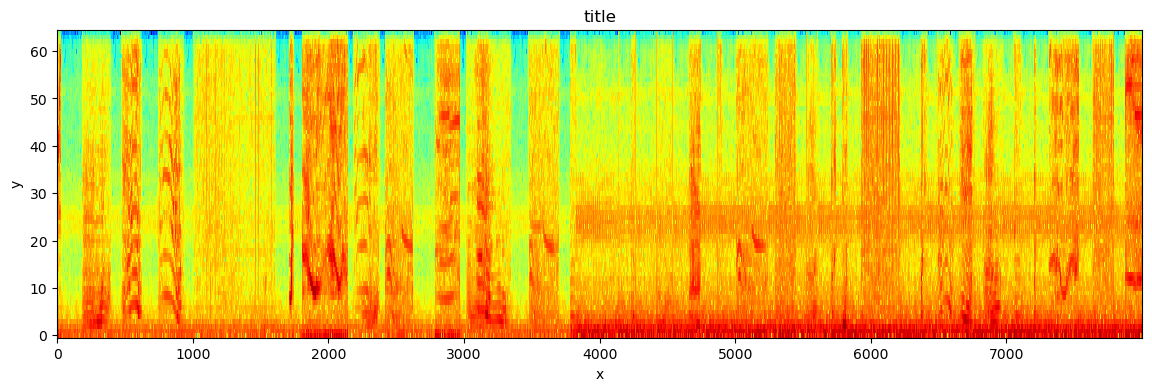

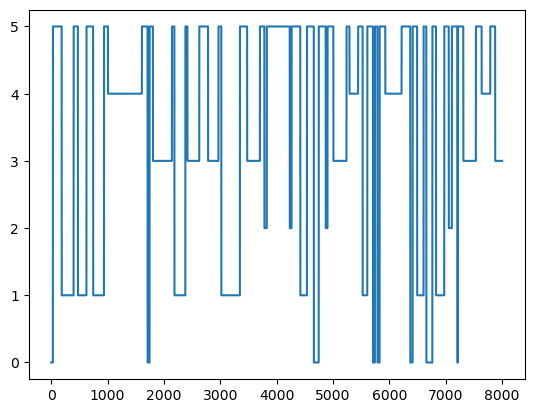

In [90]:
feature_domain_at_once = proc_method.pre_process(np.array(time_domain_at_once))
test_features_concat = np.concatenate(test_features, axis=0)
test_labels_concat = np.concatenate(test_labels, axis=0)
start_index = 11000
end_index = 19000
from spafe.utils import vis
# vis.show_features(feats=feature_domain_at_once, title='title', ylabel='y', xlabel='x')
vis.show_features(feats=test_features_concat[start_index:end_index], title='title', ylabel='y', xlabel='x')
plt.plot(test_labels_concat[start_index:end_index])

In [126]:
test_signal = {
    'test_features': test_features_concat,
    'test_labels': test_labels_concat,
    'train_features': features[fe_name]['train_features'][0],
    'train_labels': features[fe_name]['train_label'][0],
    'label_set': np.array(list(set(features[fe_name]['train_label'][0]))),
    'noise_sample_a': noise_sample_a,
    'noise_sample_b': noise_sample_b,
    'noise_sample_a_features': noise_sample_a_features,
}
import pickle
pickle.dump(test_signal, open(r'/Users/david/Documents/code/fhmm/v1/src/hmm_annots_davidjames9610/test_signals.pickle', 'wb'))

In [91]:
# train classifier
from hmmlearn.hmm import GaussianHMM, BaseHMM
import src.misc_davidjames9610.decode_combine as dc
import src.fhmm_davidjames9610.fhmm as fhmm
reload(fhmm)

label_set = np.array(list(set(features[fe_name]['train_label'][0])))

curr_features = features[fe_name]['train_features'][0]
curr_labels = features[fe_name]['train_label'][0]
n_components = 8
classifiers = {}
base_classifiers = {}

for speaker in label_set:
    print('training for speaker: ', speaker)
    mask = (np.array(curr_labels) == speaker)
    mask = mask.tolist()
    speaker_features = [array for array, flag in zip(curr_features, mask) if flag]
    speaker_features = np.array([item for sublist in speaker_features for item in sublist])

    curr_classifier = GaussianHMM(n_components=n_components, covariance_type='diag')
    curr_classifier.fit(speaker_features)

    base_classifiers[speaker] = curr_classifier

    fhmm_classifier = fhmm.FHMM(curr_classifier.n_components, n_components_b=3)
    fhmm_classifier.fit_given_signal_hmm(curr_classifier, noise_sample_a_features)
#
    classifiers[speaker] = fhmm_classifier
#
noise_hmm = GaussianHMM(n_components=4, covariance_type='diag')
noise_hmm.fit(noise_sample_a_features)

classifiers_to_combine = [classifiers[speaker_key].hmm_combined for speaker_key in
                                                  classifiers]
classifiers_to_combine.append(noise_hmm)


training for speaker:  0
training for speaker:  1
training for speaker:  2
training for speaker:  3
training for speaker:  4


In [74]:
combined_model = dc.DecodeCombineGaussian(classifiers_to_combine)
len_to_test = 4000
_, predicted_labels, val_log_prob = combined_model.decode_hmmlearn(test_features_concat[start_index:end_index])
performance_metrics = utils.get_performance_metrics(test_labels_concat[start_index:end_index], predicted_labels, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])

from collections import Counter
print(Counter(test_labels_concat[:len_to_test]))


{'precision': 0.8126640271090368, 'recall': 0.6823, 'f1-score': 0.6834690379103294, 'support': 10000, 'acc': 0.6823}
Counter({5.0: 1378, 4.0: 903, 3.0: 685, 1.0: 566, 0.0: 266, 2.0: 202})


In [95]:
import na_hmm as na_hmm
reload(na_hmm)

my_na_hmm = na_hmm.NoiseAdaptiveHMM(
    base_classifiers=base_classifiers,
    noise_features=noise_sample_a_features,
    label_set=label_set,
    noise_hmm_components=4
)


init noise adaptive hmm


In [96]:

_, predicted_labels, val_log_prob = my_na_hmm.dc_model.decode_hmmlearn(test_features_concat[start_index:end_index])
performance_metrics = utils.get_performance_metrics(test_labels_concat[start_index:end_index], predicted_labels, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])


{'precision': 0.7972954706116127, 'recall': 0.633375, 'f1-score': 0.6302198909319658, 'support': 8000, 'acc': 0.633375}


In [97]:
# Define sliding window parameters
import na_hmm as na_hmm
reload(na_hmm)

window_size = 200
step_size = 50
test_start_index = start_index
test_end_index = end_index

out = na_hmm.sliding_windows(
    data=test_features_concat[test_start_index:test_end_index],
    window_size=window_size,
    step_size=step_size,
    na_hmm=my_na_hmm,
    mean_log_prob=-25000,
    threshold=1.2)

windows_states = out['states']

performance_metrics = utils.get_performance_metrics(test_labels_concat[test_start_index:test_end_index], windows_states, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])

model updating to changing noise conditions
{'precision': 0.8865374618371484, 'recall': 0.86825, 'f1-score': 0.8739923806094412, 'support': 8000, 'acc': 0.86825}


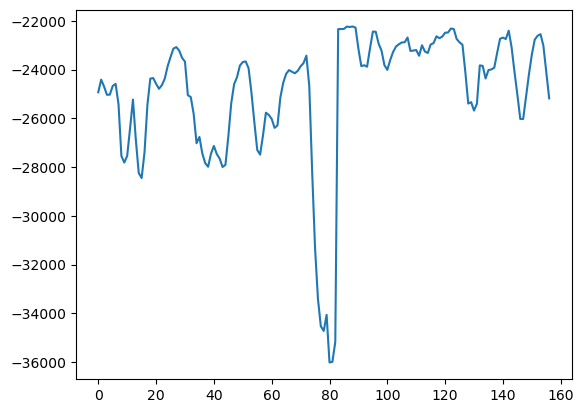

In [98]:
plt.plot(out['prob'])
plt.show()
plt.close()

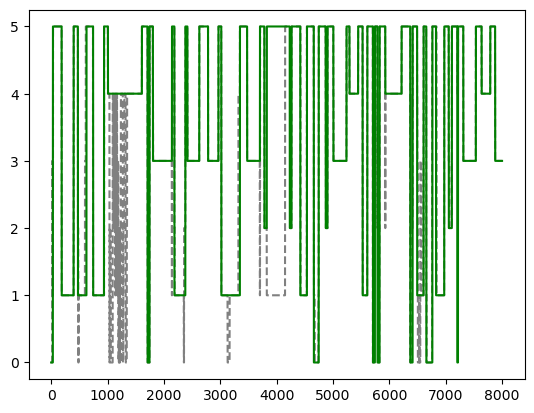

In [104]:
# plt.plot(windows_states, 'r')
reload(na_hmm)
plt.plot(na_hmm.smooth_labels(windows_states), '--', c='grey')
plt.plot(test_labels_concat[test_start_index:test_end_index], 'g')
plt.show()
plt.close()

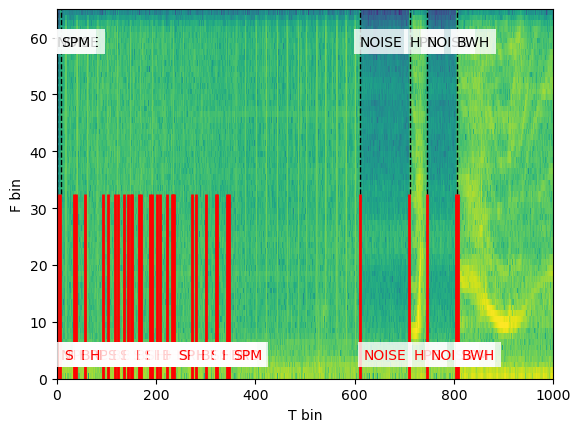

In [122]:
# label_to_abr = {
#     0: 'H',
#     1: 'B',
#     2: 'N'
# }
reload(na_hmm)
adjust_start = 1000
adjust_end = adjust_start + 1000
na_hmm.plot_spectrogram(
    features=test_features_concat[test_start_index+adjust_start:test_start_index+adjust_end],
    true_labels=test_labels_concat[test_start_index+adjust_start:test_start_index+adjust_end],
    pred_labels=na_hmm.smooth_labels(windows_states[adjust_start:adjust_end]),
    label_type=sls['num_to_label'],
    label_abr=sls['num_to_label']
)